Charter School Missing Data Imputation and Analysis
===================================================
This code uses district level data from texas to invesitagte the incidence of learning disabilities in public and private schools.  Because the initial data had missing values (to protect identity), I first investigate the sensitivity of the data to variations of mean imputation.  I then use deterministic regression imputation to fill missing values, and compare the private and charter incidence rates graphically and statistically. 

In [437]:

%matplotlib inline
import pandas as pd
import os
import numpy as np
from sklearn import linear_model
from statsmodels.discrete.discrete_model import Poisson, NegativeBinomial
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from __future__ import division
from matplotlib.backends.backend_pdf import PdfPages

home = '/home/alex/Documents/Projects/Charter Schools/Data'
os.chdir(home)
charters = 'A1608091_CHARTER.csv'
public = 'A1608091_NON_CHARTER.csv'

def calculatePct(file,lowValue=3,impute=True):

    schoolData = pd.read_csv(file)
    schoolData = schoolData.fillna(0)
    if impute:
        schoolData = imputeMissing(schoolData)  
    else:
        schoolData = schoolData.replace(to_replace=-99,value=lowValue)
    schoolData = schoolData.reset_index(drop=True)
    dataColumns = schoolData.ix[:,'AUTISM':]
    dataColumns.columns = [colName + str('_pct') for colName in dataColumns.columns]
    calcPct = lambda x: x/schoolData['STUDENTS']
    dataColumns = dataColumns.apply(calcPct)
    schoolData = pd.merge(dataColumns,schoolData,left_index=True,right_index=True)       
    return schoolData

def getSensitivtyData(file,numbers=[1,3,5]):    
    for i in numbers:
        if i == numbers[0]:
            data = calculatePct(file,lowValue=i,impute=False)
            data['lowValue'] = i
        else:
            tempData = calculatePct(file,lowValue=i,impute=False)
            tempData['lowValue'] = i
            data = data.append(tempData)
    return data

def imputeMissing(data):
    
    schoolData = data
    schoolData['STUDENTS'] = np.log(schoolData['STUDENTS'])
    for col in schoolData.columns[4:]:
        trainingData = schoolData.loc[schoolData[col] != -99]
        missingData =  schoolData.loc[schoolData[col] == -99]
        missingData = missingData.reset_index(drop=True)
        regr = linear_model.LinearRegression()
        regr.fit((trainingData['STUDENTS'].to_frame()),(trainingData[col].to_frame()))
        imputedData = pd.DataFrame(regr.predict(missingData['STUDENTS'].to_frame()))
        imputedData.ix[:,0] = imputedData.ix[:,0].apply(lambda x: max(1,min(5,round(x))))         
        missingData[col] = imputedData
        schoolData = trainingData.append(missingData)
    schoolData['STUDENTS'] = np.exp(schoolData['STUDENTS'])  
    return schoolData

def testSensitivity(data):

    keepColumns = [u'AUTISM',
       u'EMOTIONAL_DISTURBANCE', u'INTELLECTUAL_DISABILITY',
       u'LEARNING_DISABILITY', u'ORTHOPEDIC_IMPAIRMENT',
       u'OTHER_HEALTH_IMPAIRMENT', u'SPEECH_IMPAIRMENT',
       u'AUDITORY_IMPAIRMENT', u'TRAUMATIC_BRAIN_INJURY', u'VISUAL_IMPAIRMENT',
       u'NONCATEGORICAL_EARLY_CHILDHOOD', u'DEAF_BLIND']

    for col in keepColumns:
        modelP = Poisson(data[col],data['lowValue'])
        resultsP = modelP.fit()
        print(resultsP.summary())
        
        
        modelNB = NegativeBinomial(data['AUTISM_pct'],data['lowValue'])
        resultsNB = modelNB.fit()
        print(resultsNB.summary())
        
def plotSensitivity(data):
    
    keepColumns = [u'AUTISM',
       u'EMOTIONAL_DISTURBANCE', u'INTELLECTUAL_DISABILITY',
       u'LEARNING_DISABILITY', u'ORTHOPEDIC_IMPAIRMENT',
       u'OTHER_HEALTH_IMPAIRMENT', u'SPEECH_IMPAIRMENT',
       u'AUDITORY_IMPAIRMENT', u'TRAUMATIC_BRAIN_INJURY', u'VISUAL_IMPAIRMENT',
       u'NONCATEGORICAL_EARLY_CHILDHOOD', u'DEAF_BLIND']
    
    os.chdir(os.getcwd()+'/Output')
    name = [ k for k,v in locals().iteritems() if v is data]
    fileName = str(name) + ' Sensitivity'
    pp = PdfPages(fileName)
    
    for col in keepColumns:
        g = sns.FacetGrid(data, col='lowValue')  
        print(g.map(sns.distplot, col))
        pp.savefig()
        
    pp.close()
    os.chdir(home)
    
def plotIncidenceRates(charterData,publicData):
    
    columns = [u'AUTISM_pct', u'EMOTIONAL_DISTURBANCE_pct',
       u'INTELLECTUAL_DISABILITY_pct', u'LEARNING_DISABILITY_pct',
       u'ORTHOPEDIC_IMPAIRMENT_pct', u'OTHER_HEALTH_IMPAIRMENT_pct',
       u'SPEECH_IMPAIRMENT_pct', u'AUDITORY_IMPAIRMENT_pct',
       u'TRAUMATIC_BRAIN_INJURY_pct', u'VISUAL_IMPAIRMENT_pct',
       u'NONCATEGORICAL_EARLY_CHILDHOOD_pct', u'DEAF_BLIND_pct']

    
    widthList = [.02,.02,.02,.1,.005,.03,.05,.01,.005,.005,.01,.005]
    
    os.chdir(os.getcwd()+'/Output')
    pp = PdfPages('IncidenceRates')
    counter = 0
    
    for col in columns:
        width = widthList[counter]
        counter = counter + 1
        fig, ax = plt.subplots()
        sns.distplot(charterData[col], bins=np.linspace(0.0,width,25),ax=ax,kde=True, kde_kws={'bw':'.001','label':'Charter'})
        sns.distplot(publicData[col], bins=np.linspace(0.0,width,25),ax=ax,kde=True, kde_kws={'bw':'.001','label':'Public'})
        ax.set_xlim([0, width])
        print(fig)
        pp.savefig()
    
    pp.close()
    os.chdir(home)

Sensitivity Analysis
--------------------
Test multiple values as replacement for missing values

In [438]:
testNumbers = [1,3,5]
charterSensData = getSensitivtyData(charters,numbers=testNumbers)
publicSensData = getSensitivtyData(public,numbers=testNumbers)

os.chdir('/home/alex/Documents/Projects/Charter Schools/Output')

testSensitivity(charterSensData)
testSensitivity(publicSensData)



IOError: File A1608091_CHARTER.csv does not exist

plot the distributions of each variable using different replacement values

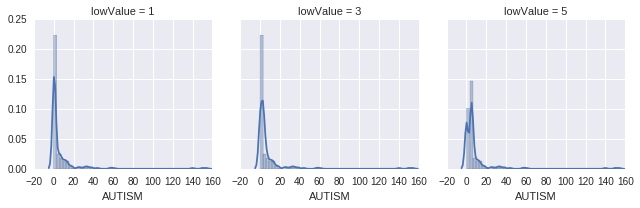

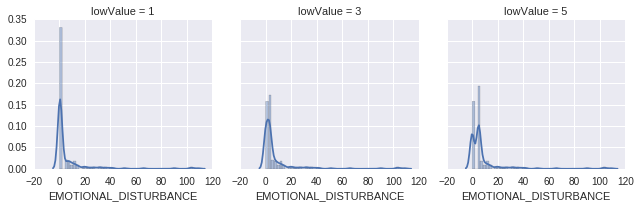

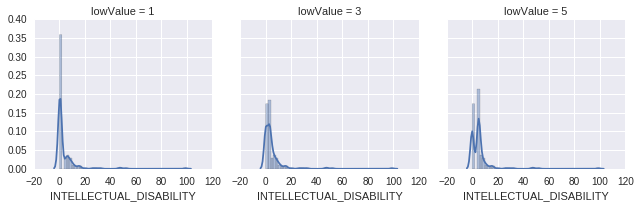

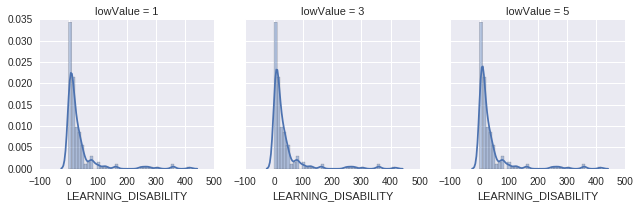

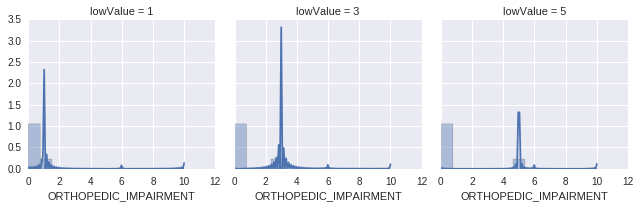

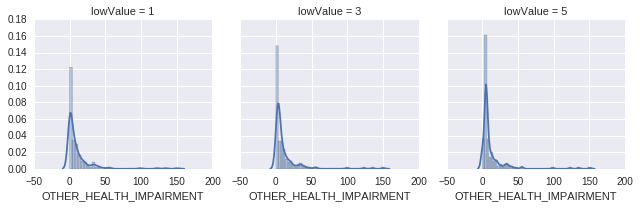

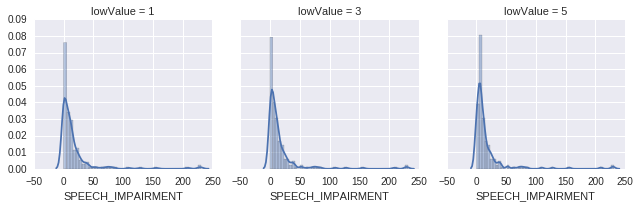

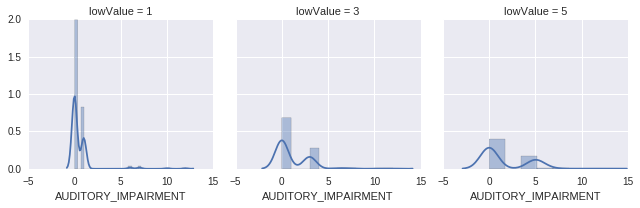

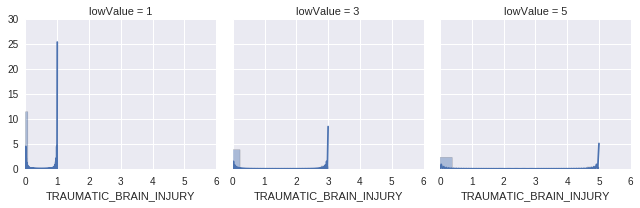

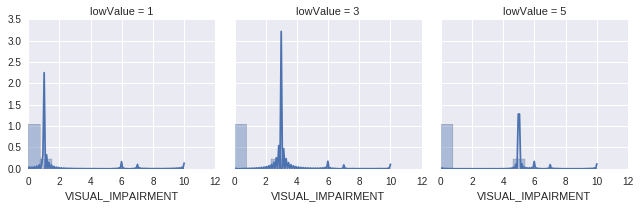

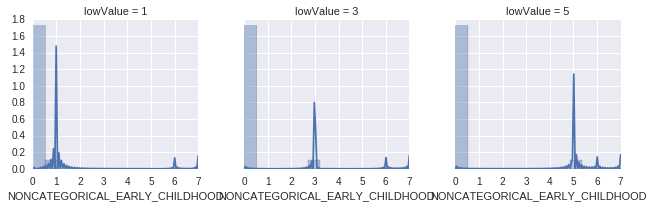

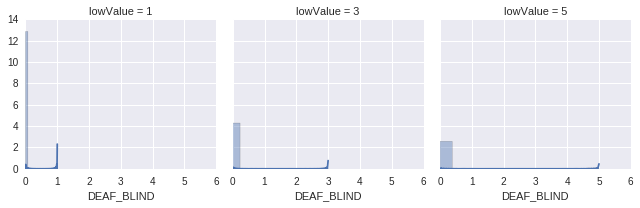

In [430]:
plotSensitivity(charterSensData)

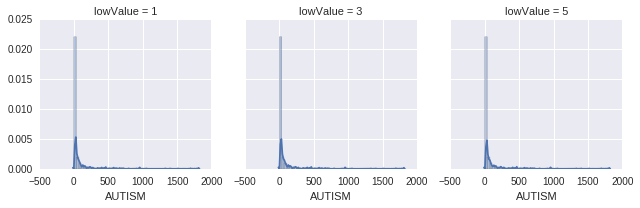

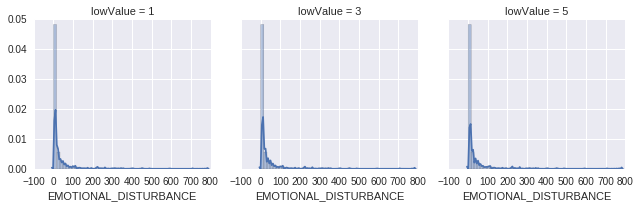

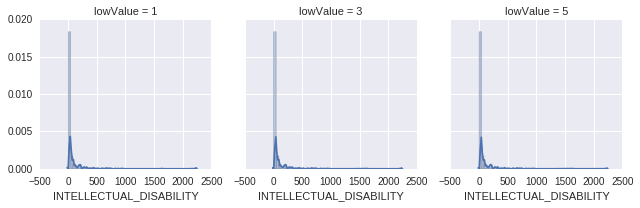

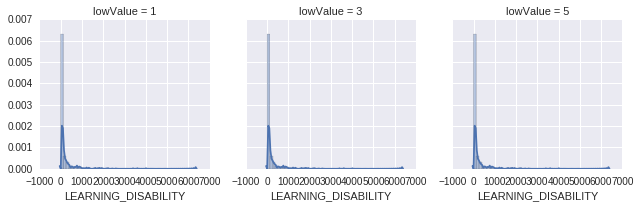

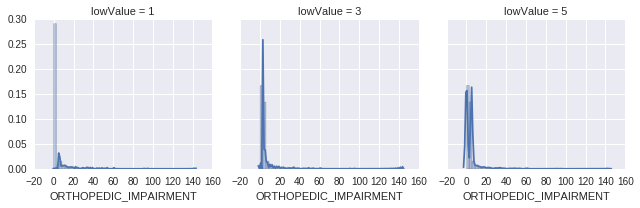

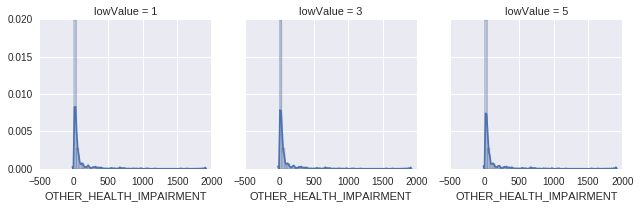

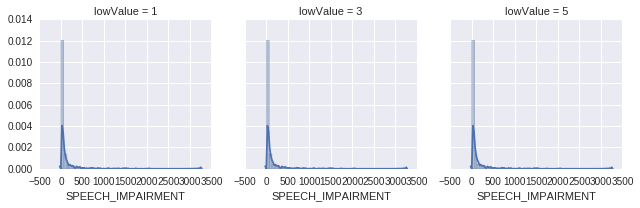

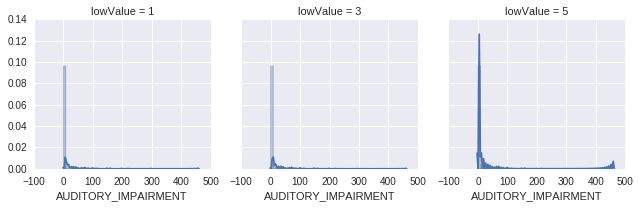

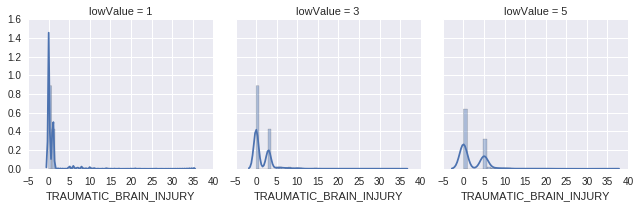

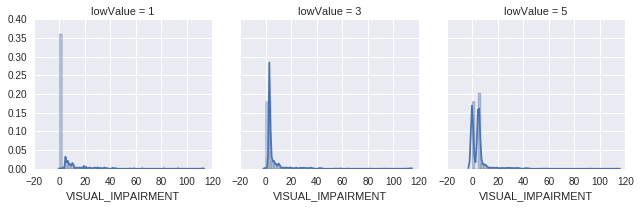

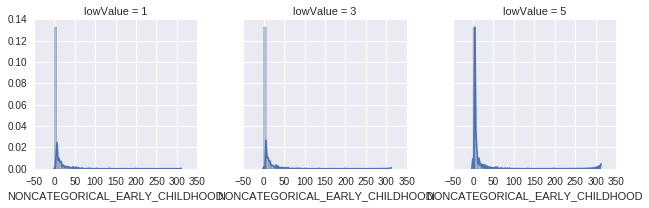

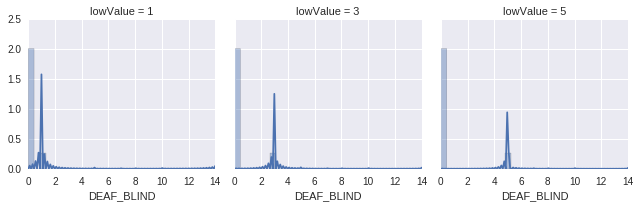

In [431]:
plotSensitivity(publicSensData)

Imputation
----
Use ***OLS*** form scikit-learn to predict values for missing data.  The *students* variable is logged.


In [432]:
charterData = calculatePct(charters)
publicData = calculatePct(public)

Analysis
--------
Plot the incidence rates for each imputed learning disability variable against each other.

Figure(480x320)
Figure(480x320)
Figure(480x320)
Figure(480x320)
Figure(480x320)
Figure(480x320)
Figure(480x320)
Figure(480x320)
Figure(480x320)
Figure(480x320)
Figure(480x320)
Figure(480x320)


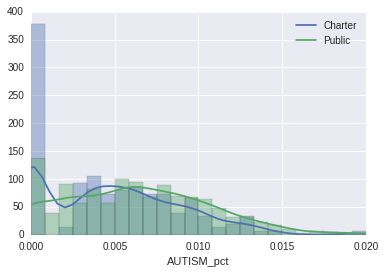

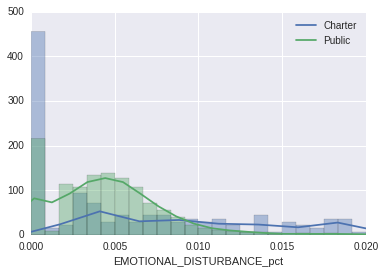

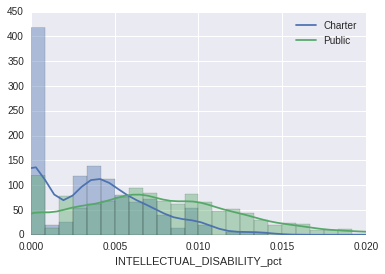

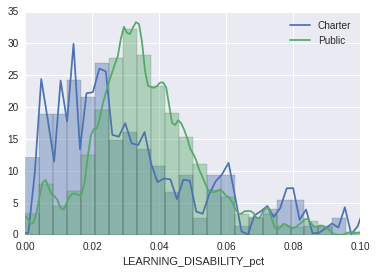

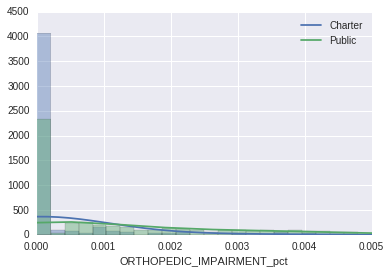

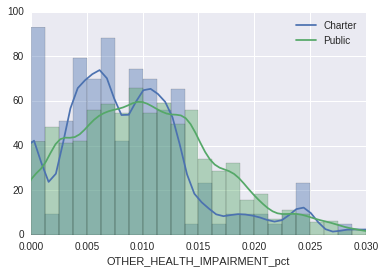

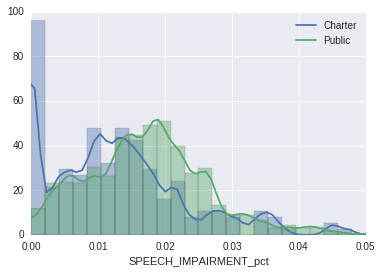

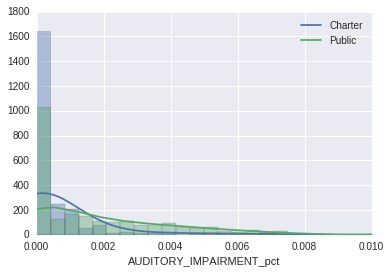

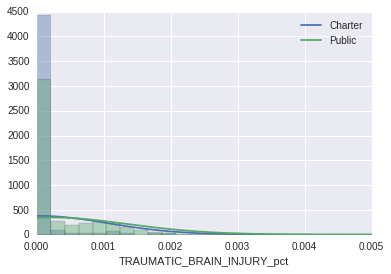

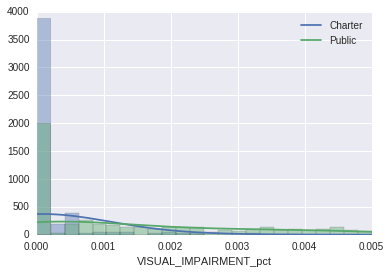

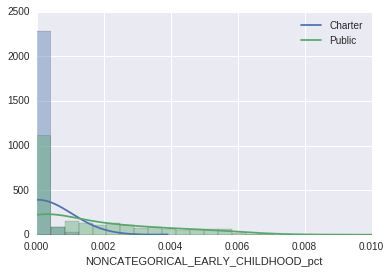

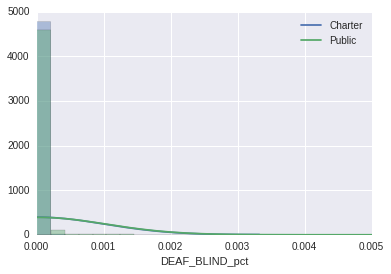

In [420]:
plotIncidenceRates(charterData,publicData)

Calculate aggregates from the data, and compare the Public and Charter aggregates using a statistical test

In [434]:
dataTotals = pd.DataFrame(charterData.ix[:,15:].apply(np.sum, axis=0))
dataTotals.columns = ['Charter Total']
dataTotals['Percent of Charter Students'] = dataTotals.apply(lambda x : x*100 / dataTotals.iloc[0]['Charter Total'], axis=0)

dataTotals_temp = pd.DataFrame(publicData.ix[:,16:].apply(np.sum, axis=0))
dataTotals_temp.columns = ['Public Total']
dataTotals_temp['Percent of Public Students'] = dataTotals_temp.apply(lambda x : x*100 / dataTotals_temp.iloc[0]['Public Total'], axis=0)

dataTotals = pd.merge(dataTotals, dataTotals_temp, right_index=True, left_index=True)
dataTotals['Incidence Rate Ratio'] = dataTotals['Percent of Public Students']/dataTotals['Percent of Charter Students']
dataTotals['95% confidence interval'] = map(lambda x: (np.exp(np.log(x)+1.96*np.sqrt(1/len(publicData)+1/len(charterData))),np.exp(np.log(x)-1.96*np.sqrt(1/len(publicData)+1/len(charterData)))),dataTotals['Incidence Rate Ratio'])
dataTotals

,Charter Total,Percent of Charter Students,Public Total,Percent of Public Students,Incidence Rate Ratio,95% confidence interval
STUDENTS,247389,100.000000,5052339,100.000000,1.000000,"(1.17034897998, 0.854445996114)"
AUTISM,1502,0.607141,52510,1.039321,1.711827,"(2.00343551687, 1.4626641157)"
EMOTIONAL_DISTURBANCE,1547,0.625331,25531,0.505330,0.808101,"(0.945759679796, 0.690478297936)"
INTELLECTUAL_DISABILITY,920,0.371884,45265,0.895922,2.409143,"(2.8195381837, 2.05848268607)"
LEARNING_DISABILITY,6947,2.808128,152443,3.017276,1.074479,"(1.2575158597, 0.918084613865)"
NONCATEGORICAL_EARLY_CHILDHOOD,24,0.009701,6134,0.121409,12.514700,"(14.6465660014, 10.6931350313)"
ORTHOPEDIC_IMPAIRMENT,49,0.019807,4498,0.089028,4.494809,"(5.26049550842, 3.84057183083)"
OTHER_HEALTH_IMPAIRMENT,2149,0.868672,60361,1.194714,1.375333,"(1.6096197555, 1.17514790791)"
SPEECH_IMPAIRMENT,3191,1.289871,88516,1.751981,1.358260,"(1.58963808426, 1.16055973014)"
VISUAL_IMPAIRMENT,71,0.028700,4704,0.093105,3.244120,"(3.79675214871, 2.7719250644)"


export data to file

In [401]:
os.chdir(os.getcwd()+'/Output')

In [ ]:
dataTotals.to_csv('Summary Statistics After Imputation.csv')

In [411]:
charterData.to_csv('Charter Data with Imputed Values.csv')

In [412]:
publicData.to_csv('Public Data with Imputed Values.csv')